### 1. Imports + Config + Seed

In [32]:
# imports
import os
import sys
import shutil
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [33]:
# add project root to PYTHONPATH
notebook_dir = Path.cwd()
project_root = notebook_dir.parent if notebook_dir.name == "notebooks" else notebook_dir
sys.path.insert(0, str(project_root))

print("Project root added to sys.path:", project_root)

Project root added to sys.path: /Users/shrutisivakumar/Library/CloudStorage/OneDrive-Personal/College Stuff/Sem 6/Projects/NLP/Facebook-Hateful-Memes-Challenge-2020


In [34]:
# src modules
from src.utils import Config, seed_everything
from src.dataset import HatefulMemesDataset, collate_fn
from src.model import MultimodalHatefulMemes
from src.train_eval import train_one_epoch, evaluate

In [35]:
# config
cfg = Config(
    subset_size=100,
    batch_size=8,
    epochs=5,        # keep small for fast demo; increase later
    lr=1e-3,
    max_length=128
)

seed_everything(cfg.seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("Config:", cfg)

Device: cpu
Config: Config(embedding_dim=512, num_classes=2, batch_size=8, lr=0.001, epochs=5, max_length=128, subset_size=100, seed=42, num_workers=0, pin_memory=True)


### 2. Paths + Sanity Checks + Load Data Preview

In [36]:
# Project structure
data_dir = project_root / "data"
original_dir = data_dir / "original"
processed_dir = data_dir / "processed"

img_dir = original_dir / "img"
train_jsonl = original_dir / "train.jsonl"

models_dir = project_root / "models"
results_dir = project_root / "results"

processed_dir.mkdir(parents=True, exist_ok=True)
models_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)

# Verify required data exists
if not img_dir.exists():
    raise FileNotFoundError(f"Image directory not found: {img_dir}")
if not train_jsonl.exists():
    raise FileNotFoundError(f"Train file not found: {train_jsonl}")

print("Project root :", project_root)
print("Train JSONL  :", train_jsonl)
print("Image dir    :", img_dir)
print("#images (.png):", len(list(img_dir.glob("*.png"))))

Project root : /Users/shrutisivakumar/Library/CloudStorage/OneDrive-Personal/College Stuff/Sem 6/Projects/NLP/Facebook-Hateful-Memes-Challenge-2020
Train JSONL  : /Users/shrutisivakumar/Library/CloudStorage/OneDrive-Personal/College Stuff/Sem 6/Projects/NLP/Facebook-Hateful-Memes-Challenge-2020/data/original/train.jsonl
Image dir    : /Users/shrutisivakumar/Library/CloudStorage/OneDrive-Personal/College Stuff/Sem 6/Projects/NLP/Facebook-Hateful-Memes-Challenge-2020/data/original/img
#images (.png): 10000


In [37]:
# Load full dataset
df = pd.read_json(train_jsonl, lines=True)
print("Loaded train.jsonl")
print("df.shape:", df.shape)

# Show a few rows (important for viva)
display(df[["img", "text", "label"]].head(5))

print("\nLabel distribution (full data):")
print(df["label"].value_counts())

Loaded train.jsonl
df.shape: (8500, 4)


,img,text,label
0,img/42953.png,its their character not their color that matters,0
1,img/23058.png,don't be afraid to love again everyone is not ...,0
2,img/13894.png,putting bows on your pet,0
3,img/37408.png,i love everything and everybody! except for sq...,0
4,img/82403.png,"everybody loves chocolate chip cookies, even h...",0



Label distribution (full data):
label
0    5450
1    3050
Name: count, dtype: int64


In [38]:
# Resolve one row to confirm path logic
row0 = df.iloc[0]
img_name0 = Path(str(row0["img"]).replace("\\", "/")).name
resolved0 = img_dir / img_name0
print("\nSanity path check:")
print("row['img'] :", row0["img"])
print("img_name   :", img_name0)
print("resolved   :", resolved0)
print("exists?    :", resolved0.exists())
print("text (first 80 chars):", row0["text"][:80], "...")
print("label:", int(row0["label"]))


Sanity path check:
row['img'] : img/42953.png
img_name   : 42953.png
resolved   : /Users/shrutisivakumar/Library/CloudStorage/OneDrive-Personal/College Stuff/Sem 6/Projects/NLP/Facebook-Hateful-Memes-Challenge-2020/data/original/img/42953.png
exists?    : True
text (first 80 chars): its their character not their color that matters ...
label: 0


### Define sample + display image + preprocessing tensor stats

In [39]:
# Sample data
sample_img_path = img_dir / "02657.png"
sample_text = "oh look someone's returning a broken sandwich maker to walmart"

print("Sample image path:", sample_img_path)
print("Exists?", sample_img_path.exists())
print("Sample text:", sample_text)

Sample image path: /Users/shrutisivakumar/Library/CloudStorage/OneDrive-Personal/College Stuff/Sem 6/Projects/NLP/Facebook-Hateful-Memes-Challenge-2020/data/original/img/02657.png
Exists? True
Sample text: oh look someone's returning a broken sandwich maker to walmart


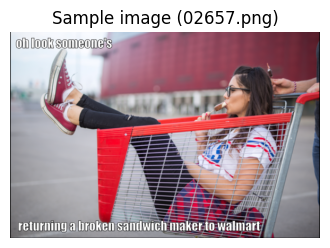

In [40]:
# Display the image
img = Image.open(sample_img_path).convert("RGB")
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis("off")
plt.title("Sample image (02657.png)")
plt.show()

In [41]:
# Same transform used in training
img_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [42]:
# Convert sample to tensor
img_tensor = img_tf(img).unsqueeze(0).to(device)  # [1,3,224,224]

print("\nImage tensor stats (after preprocessing):")
print("Shape:", img_tensor.shape)
print("Dtype:", img_tensor.dtype)
print("Min/Max:", float(img_tensor.min()), float(img_tensor.max()))
print("Mean/Std:", float(img_tensor.mean()), float(img_tensor.std()))


Image tensor stats (after preprocessing):
Shape: torch.Size([1, 3, 224, 224])
Dtype: torch.float32
Min/Max: -2.0357141494750977 2.640000104904175
Mean/Std: 0.3460867702960968 1.077589511871338

Shape: torch.Size([1, 3, 224, 224])
Dtype: torch.float32
Min/Max: -2.0357141494750977 2.640000104904175
Mean/Std: 0.3460867702960968 1.077589511871338


### 3. Image Embedding (ResNet50 backbone → 2048-d → projection → 512-d)

In [43]:
# Initialize the multimodal model (untrained head/projections initially)
model = MultimodalHatefulMemes(embedding_dim=cfg.embedding_dim, num_classes=cfg.num_classes).to(device)
model.eval()

print("Model initialized")
print("Image encoder:", type(model.image_encoder))
print("Text encoder :", type(model.text_encoder))
print("Fusion head  :", type(model.fusion))

Model initialized
Image encoder: <class 'src.encoders.ImageEncoder'>
Text encoder : <class 'src.encoders.TextEncoder'>
Fusion head  : <class 'src.fusion.FusionClassifier'>


In [44]:
# NOTE: In src/encoders.py, ImageEncoder stores:
#   self.backbone (ResNet without FC)
#   self.projection (Linear 2048 -> 512)

with torch.no_grad():
    backbone_out = model.image_encoder.backbone(img_tensor)   # [1,2048,1,1]
    backbone_flat = backbone_out.flatten(1)                   # [1,2048]
    img_emb = model.image_encoder.projection(backbone_flat)   # [1,512]

print("\n[Image Encoder Intermediate Outputs]")
print("Input image tensor shape      :", img_tensor.shape)
print("Backbone output shape         :", backbone_out.shape)
print("Backbone flattened shape      :", backbone_flat.shape)
print("Projected image embedding shape:", img_emb.shape)

print("\nFirst 10 embedding values:")
print(img_emb[0, :10].detach().cpu().numpy())


[Image Encoder Intermediate Outputs]
Input image tensor shape      : torch.Size([1, 3, 224, 224])
Backbone output shape         : torch.Size([1, 2048, 1, 1])
Backbone flattened shape      : torch.Size([1, 2048])
Projected image embedding shape: torch.Size([1, 512])

First 10 embedding values:
[-0.02376413  0.25740093 -0.12494981  0.1351396  -0.19588102  0.42139274
 -0.16452007 -0.43469983 -0.11707897 -0.09035996]


### 4. Text Embedding (Tokenizer → IDs/mask → DistilBERT → CLS → projection → 512-d)

In [45]:
tokenizer = model.text_encoder.tokenizer
print("Tokenizer loaded:", tokenizer.__class__.__name__)

Tokenizer loaded: DistilBertTokenizerFast
 DistilBertTokenizerFast


In [46]:
# Tokenize (show tokens, IDs, masks)
enc = tokenizer(
    [sample_text],
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=cfg.max_length
)

input_ids = enc["input_ids"]          # [1, seq_len]
attention_mask = enc["attention_mask"] # [1, seq_len]

print("\n[Tokenization Outputs]")
print("input_ids shape     :", input_ids.shape)
print("attention_mask shape:", attention_mask.shape)

print("\nFirst 25 token IDs:")
print(input_ids[0, :25].tolist())

print("\nFirst 25 tokens:")
print(tokenizer.convert_ids_to_tokens(input_ids[0, :25].tolist()))

print("\nDecoded back (sanity):")
print(tokenizer.decode(input_ids[0]))

# Move token tensors to device (this matches what happens inside TextEncoder.forward)
enc = {k: v.to(device) for k, v in enc.items()}


[Tokenization Outputs]
input_ids shape     : torch.Size([1, 15])
attention_mask shape: torch.Size([1, 15])

First 25 token IDs:
[101, 2821, 2298, 2619, 1005, 1055, 4192, 1037, 3714, 11642, 9338, 2000, 24547, 22345, 102]

First 25 tokens:
['[CLS]', 'oh', 'look', 'someone', "'", 's', 'returning', 'a', 'broken', 'sandwich', 'maker', 'to', 'wal', '##mart', '[SEP]']

Decoded back (sanity):
[CLS] oh look someone ' s returning a broken sandwich maker to walmart [SEP]


In [47]:
# DistilBERT forward (show hidden state shapes)
with torch.no_grad():
    bert_out = model.text_encoder.bert(**enc)
    last_hidden = bert_out.last_hidden_state  # [1, seq_len, 768]
    cls_vec = last_hidden[:, 0, :]            # [1, 768]
    txt_emb = model.text_encoder.projection(cls_vec)  # [1, 512]

print("\n[DistilBERT Intermediate Outputs]")
print("last_hidden_state shape:", last_hidden.shape)
print("CLS vector shape        :", cls_vec.shape)
print("Projected text embedding shape:", txt_emb.shape)

print("\nFirst 10 text embedding values:")
print(txt_emb[0, :10].detach().cpu().numpy())


[DistilBERT Intermediate Outputs]
last_hidden_state shape: torch.Size([1, 15, 768])
CLS vector shape        : torch.Size([1, 768])
Projected text embedding shape: torch.Size([1, 512])

First 10 text embedding values:
[ 0.54221094  0.26385075  0.3009263  -0.04756489  0.00839023 -0.2949242
 -0.22057989 -0.008795    0.33256596 -0.24706069]


### 5. Fusion (Concatenate embeddings → MLP → logits → softmax → prediction)

In [48]:
with torch.no_grad():
    fused = torch.cat([img_emb, txt_emb], dim=1)   # [1, 1024]
    logits = model.fusion(img_emb, txt_emb)        # [1, 2]
    probs = torch.softmax(logits, dim=1)           # [1, 2]
    pred = int(torch.argmax(probs, dim=1).item())

print("[Fusion Intermediate Outputs]")
print("Image embedding shape:", img_emb.shape)
print("Text embedding shape :", txt_emb.shape)
print("Fused vector shape   :", fused.shape)

print("\nLogits (raw scores):")
print(logits.detach().cpu().numpy())

print("\nSoftmax probabilities:")
print(probs.detach().cpu().numpy())

print("\nPrediction (UNTRAINED model):", pred, "|", "Hateful" if pred == 1 else "Not Hateful")
print("Confidence:", float(probs[0, pred].item()))

[Fusion Intermediate Outputs]
Image embedding shape: torch.Size([1, 512])
Text embedding shape : torch.Size([1, 512])
Fused vector shape   : torch.Size([1, 1024])

Logits (raw scores):
[[0.07265171 0.00428167]]

Softmax probabilities:
[[0.51708585 0.48291415]]

Prediction (UNTRAINED model): 0 | Not Hateful
Confidence: 0.5170858502388


### Create stratified subset + save JSONL to processed/

In [49]:
# stratified subset from full df
subset_df, _ = train_test_split(
    df,
    train_size=cfg.subset_size,
    stratify=df["label"],
    random_state=cfg.seed
)

train_df, val_df = train_test_split(
    subset_df,
    test_size=0.2,
    stratify=subset_df["label"],
    random_state=cfg.seed
)

print("Subset created")
print("Subset size:", len(subset_df))
print("Train size :", len(train_df))
print("Val size   :", len(val_df))

print("\nLabel distribution (train):")
print(train_df["label"].value_counts())

print("\nLabel distribution (val):")
print(val_df["label"].value_counts())

print("\nSample train rows:")
display(train_df[["img", "text", "label"]].head(3))

Subset created
Subset size: 100
Train size : 80
Val size   : 20

Label distribution (train):
label
0    51
1    29
Name: count, dtype: int64

Label distribution (val):
label
0    13
1     7
Name: count, dtype: int64

Sample train rows:


,img,text,label
3108,img/41372.png,mississippi wind chime,1
625,img/82379.png,there's so much white trash in this picture i ...,0
3281,img/17624.png,just trying to do my part,0


In [50]:
# Save JSONL files directly under processed/
train_subset_path = processed_dir / "train.jsonl"
val_subset_path   = processed_dir / "val.jsonl"

train_df.to_json(train_subset_path, orient="records", lines=True)
val_df.to_json(val_subset_path, orient="records", lines=True)

print("\nSaved JSONL files:")
print("Train:", train_subset_path)
print("Val  :", val_subset_path)


Saved JSONL files:
Train: /Users/shrutisivakumar/Library/CloudStorage/OneDrive-Personal/College Stuff/Sem 6/Projects/NLP/Facebook-Hateful-Memes-Challenge-2020/data/processed/train.jsonl
Val  : /Users/shrutisivakumar/Library/CloudStorage/OneDrive-Personal/College Stuff/Sem 6/Projects/NLP/Facebook-Hateful-Memes-Challenge-2020/data/processed/val.jsonl


In [51]:
# Create processed image folders
train_img_dir = processed_dir / "img" / "train"
val_img_dir   = processed_dir / "img" / "val"

train_img_dir.mkdir(parents=True, exist_ok=True)
val_img_dir.mkdir(parents=True, exist_ok=True)

print("\nProcessed image dirs:")
print("Train images:", train_img_dir)
print("Val images  :", val_img_dir)

# Copy images for each split
def copy_images(df_split, src_img_dir: Path, dst_img_dir: Path):
    missing = 0
    for img_field in df_split["img"].tolist():
        img_name = Path(str(img_field).replace("\\", "/")).name
        src = src_img_dir / img_name
        dst = dst_img_dir / img_name

        if src.exists():
            shutil.copy2(src, dst)
        else:
            missing += 1
    return missing

missing_train = copy_images(train_df, img_dir, train_img_dir)
missing_val   = copy_images(val_df, img_dir, val_img_dir)

print("\nImage copying done")
print("Train images copied:", len(list(train_img_dir.glob("*.png"))))
print("Val images copied  :", len(list(val_img_dir.glob("*.png"))))
print("Missing train images:", missing_train)
print("Missing val images  :", missing_val)


Processed image dirs:
Train images: /Users/shrutisivakumar/Library/CloudStorage/OneDrive-Personal/College Stuff/Sem 6/Projects/NLP/Facebook-Hateful-Memes-Challenge-2020/data/processed/img/train
Val images  : /Users/shrutisivakumar/Library/CloudStorage/OneDrive-Personal/College Stuff/Sem 6/Projects/NLP/Facebook-Hateful-Memes-Challenge-2020/data/processed/img/val

Image copying done
Train images copied: 256
Val images copied  : 77
Missing train images: 0
Missing val images  : 0


### 6. Build DataLoaders from processed/ + inspect first batch (shapes + token IDs)

In [52]:
# Datasets read from processed/ paths and processed/img/* folders
train_ds = HatefulMemesDataset(
    jsonl_path=str(train_subset_path),
    img_dir=str(train_img_dir),
    transform=img_tf
)

val_ds = HatefulMemesDataset(
    jsonl_path=str(val_subset_path),
    img_dir=str(val_img_dir),
    transform=img_tf
)

train_loader = DataLoader(
    train_ds,
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=cfg.num_workers,
    pin_memory=cfg.pin_memory,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_ds,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=cfg.num_workers,
    pin_memory=cfg.pin_memory,
    collate_fn=collate_fn
)

print("DataLoaders created")
print("Train batches:", len(train_loader))
print("Val batches  :", len(val_loader))

DataLoaders created
Train batches: 10
Val batches  : 3


In [53]:
# Inspect FIRST training batch
images_b, texts_b, labels_b = next(iter(train_loader))

print("\n[First Train Batch]")
print("Images batch shape:", images_b.shape)   # [B,3,224,224]
print("Labels batch shape:", labels_b.shape)   # [B]
print("Labels:", labels_b.tolist())

print("\nSample texts:")
for i in range(min(3, len(texts_b))):
    print(f"{i+1}) {texts_b[i][:80]}...")


[First Train Batch]
Images batch shape: torch.Size([8, 3, 224, 224])
Labels batch shape: torch.Size([8])
Labels: [0, 0, 1, 0, 0, 1, 0, 1]

Sample texts:
1) we shall snort cocaine and have our assholes tongued by the angels...
2) im gonna be a woman...
3) great at making martinis terrible at stealing tambourines...


/Users/shrutisivakumar/Library/CloudStorage/OneDrive-Personal/College Stuff/Sem 6/Projects/NLP/Facebook-Hateful-Memes-Challenge-2020/hateful_memes_venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


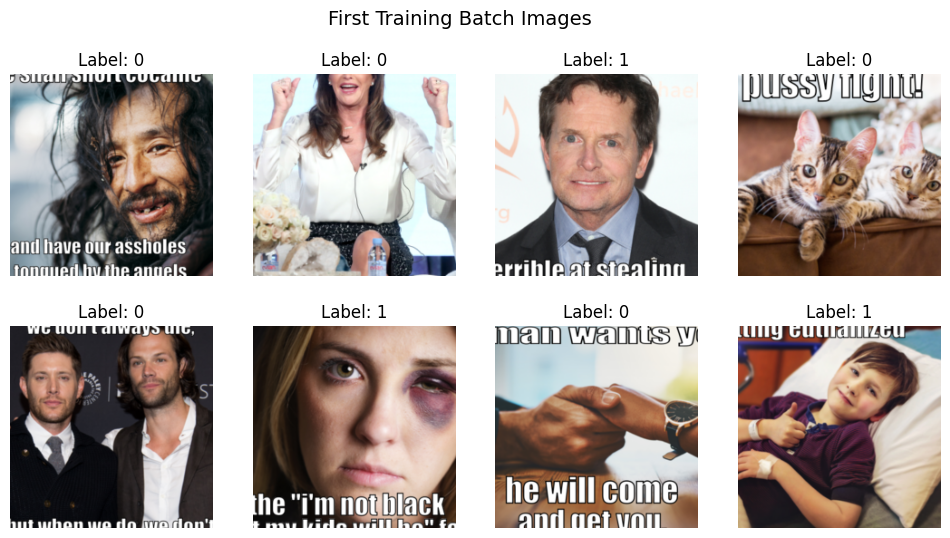

In [54]:
# Display images in the batch
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return img_tensor * std + mean

num_to_show = min(8, images_b.shape[0])
plt.figure(figsize=(12, 6))

for i in range(num_to_show):
    plt.subplot(2, 4, i + 1)
    img = denormalize(images_b[i]).permute(1, 2, 0).cpu().numpy()
    plt.imshow(img)
    plt.title(f"Label: {labels_b[i].item()}")
    plt.axis("off")

plt.suptitle("First Training Batch Images", fontsize=14)
plt.show()

### 7. Training loop + save best model

In [55]:
# Fresh model for training
model = MultimodalHatefulMemes(
    embedding_dim=cfg.embedding_dim,
    num_classes=cfg.num_classes
).to(device)

# Train only parameters that require gradients (frozen backbones won't train)
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable_params, lr=cfg.lr)
criterion = nn.CrossEntropyLoss()

best_acc = -1.0
best_path = models_dir / "best_model.pth"

print("Trainable parameters:", sum(p.numel() for p in trainable_params))
print("Training epochs:", cfg.epochs)

Trainable parameters: 1738370
Training epochs: 5


In [56]:
for epoch in range(cfg.epochs):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, device, cfg
    )

    val_acc, val_auc, y_true, y_pred, y_prob = evaluate(
        model, val_loader, device, cfg
    )

    print(
        f"Epoch {epoch+1:02d} | "
        f"TrainLoss={train_loss:.4f} "
        f"TrainAcc={train_acc:.4f} | "
        f"ValAcc={val_acc:.4f} "
        f"ValAUC={val_auc:.4f}"
    )

    # Sanity: mean probability of hateful class
    print("  Mean P(hateful):", np.mean(y_prob))

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(
            {
                "model_state": model.state_dict(),
                "epoch": epoch,
                "val_acc": val_acc,
                "val_auc": val_auc,
                "config": cfg.__dict__,
            },
            best_path
        )
        print("Saved new best model")

print("\nTraining finished.")
print("Best validation accuracy:", best_acc)
print("Model saved at:", best_path)

Epoch 01 | TrainLoss=0.6490 TrainAcc=0.6375 | ValAcc=0.6500 ValAUC=0.6154
  Mean P(hateful): 0.31541687
Saved new best model


Train:   0%|          | 0/10 [00:00<?, ?it/s]/Users/shrutisivakumar/Library/CloudStorage/OneDrive-Personal/College Stuff/Sem 6/Projects/NLP/Facebook-Hateful-Memes-Challenge-2020/hateful_memes_venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 02 | TrainLoss=0.6572 TrainAcc=0.6125 | ValAcc=0.6500 ValAUC=0.6374
  Mean P(hateful): 0.31118855


Train:   0%|          | 0/10 [00:00<?, ?it/s]/Users/shrutisivakumar/Library/CloudStorage/OneDrive-Personal/College Stuff/Sem 6/Projects/NLP/Facebook-Hateful-Memes-Challenge-2020/hateful_memes_venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 03 | TrainLoss=0.5566 TrainAcc=0.6875 | ValAcc=0.5500 ValAUC=0.7692
  Mean P(hateful): 0.5712941


Train:   0%|          | 0/10 [00:00<?, ?it/s]/Users/shrutisivakumar/Library/CloudStorage/OneDrive-Personal/College Stuff/Sem 6/Projects/NLP/Facebook-Hateful-Memes-Challenge-2020/hateful_memes_venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 04 | TrainLoss=0.4256 TrainAcc=0.7750 | ValAcc=0.7000 ValAUC=0.7253
  Mean P(hateful): 0.46700072
Saved new best model


Train:   0%|          | 0/10 [00:00<?, ?it/s]/Users/shrutisivakumar/Library/CloudStorage/OneDrive-Personal/College Stuff/Sem 6/Projects/NLP/Facebook-Hateful-Memes-Challenge-2020/hateful_memes_venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
                                                      

Epoch 05 | TrainLoss=0.1970 TrainAcc=0.9500 | ValAcc=0.5500 ValAUC=0.7143
  Mean P(hateful): 0.7306604

Training finished.
Best validation accuracy: 0.7
Model saved at: /Users/shrutisivakumar/Library/CloudStorage/OneDrive-Personal/College Stuff/Sem 6/Projects/NLP/Facebook-Hateful-Memes-Challenge-2020/models/best_model.pth


### Evaluation metrics (classification report + confusion matrix)

In [57]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report
)

In [58]:
# Convert to numpy arrays (safety)
y_true_np = np.array(y_true)
y_pred_np = np.array(y_pred)
y_prob_np = np.array(y_prob)  # probability for class 1 ("Hateful")

# Core metrics
acc = accuracy_score(y_true_np, y_pred_np)

# Treat class "1" (Hateful) as the positive class
prec = precision_score(y_true_np, y_pred_np, pos_label=1, zero_division=0)
rec  = recall_score(y_true_np, y_pred_np, pos_label=1, zero_division=0)
f1   = f1_score(y_true_np, y_pred_np, pos_label=1, zero_division=0)

# Threshold-free metrics (need probabilities)
roc_auc = roc_auc_score(y_true_np, y_prob_np) if len(np.unique(y_true_np)) > 1 else float("nan")
pr_auc  = average_precision_score(y_true_np, y_prob_np) if len(np.unique(y_true_np)) > 1 else float("nan")

print("===== VALIDATION METRICS =====")
print(f"Accuracy        : {acc:.4f}")
print(f"Precision (pos=Hateful) : {prec:.4f}")
print(f"Recall    (pos=Hateful) : {rec:.4f}")
print(f"F1-score  (pos=Hateful) : {f1:.4f}")
print(f"ROC-AUC         : {roc_auc:.4f}")
print(f"PR-AUC (AvgPrec): {pr_auc:.4f}")

print("\n===== CLASSIFICATION REPORT =====")
print(classification_report(
    y_true_np,
    y_pred_np,
    target_names=["Not Hateful", "Hateful"],
    zero_division=0
))

===== VALIDATION METRICS =====
Accuracy        : 0.5500
Precision (pos=Hateful) : 0.4375
Recall    (pos=Hateful) : 1.0000
F1-score  (pos=Hateful) : 0.6087
ROC-AUC         : 0.7143
PR-AUC (AvgPrec): 0.4961

===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

 Not Hateful       1.00      0.31      0.47        13
     Hateful       0.44      1.00      0.61         7

    accuracy                           0.55        20
   macro avg       0.72      0.65      0.54        20
weighted avg       0.80      0.55      0.52        20



In [59]:
# Confusion matrix + derived error rates
cm = confusion_matrix(y_true_np, y_pred_np)
tn, fp, fn, tp = cm.ravel()

fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

print("===== CONFUSION MATRIX (counts) =====")
print(cm)
print("\nDerived rates:")
print(f"Specificity (TNR): {specificity:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")

===== CONFUSION MATRIX (counts) =====
[[4 9]
 [0 7]]

Derived rates:
Specificity (TNR): 0.3077
False Positive Rate (FPR): 0.6923
False Negative Rate (FNR): 0.0000


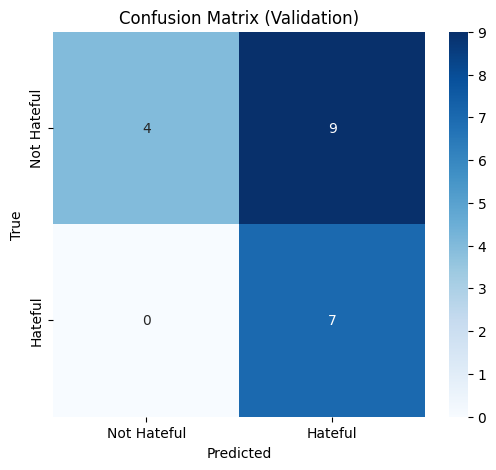


Confusion matrix saved to: /Users/shrutisivakumar/Library/CloudStorage/OneDrive-Personal/College Stuff/Sem 6/Projects/NLP/Facebook-Hateful-Memes-Challenge-2020/results/confusion_matrix.png


In [60]:
# Plot + save confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Not Hateful", "Hateful"],
    yticklabels=["Not Hateful", "Hateful"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Validation)")
plt.show()

cm_path = results_dir / "confusion_matrix.png"
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Not Hateful", "Hateful"],
    yticklabels=["Not Hateful", "Hateful"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Validation)")
plt.savefig(cm_path, dpi=150, bbox_inches="tight")
plt.close()

print("\nConfusion matrix saved to:", cm_path)

### Final prediction on SAMPLE

In [61]:
# Load best checkpoint
best_model_path = models_dir / "best_model.pth"
assert best_model_path.exists(), f"Missing model file: {best_model_path}"

# Re-create model architecture
model = MultimodalHatefulMemes(
    embedding_dim=cfg.embedding_dim,
    num_classes=cfg.num_classes
).to(device)

# Load trained weights
ckpt = torch.load(best_model_path, map_location=device)
model.load_state_dict(ckpt["model_state"])
model.eval()

print("Loaded trained model from:", best_model_path)
print("  Trained epochs:", ckpt["epoch"] + 1)
print("  Best Val Acc  :", ckpt["val_acc"])
print("  Best Val AUC  :", ckpt["val_auc"])


Loaded trained model from: /Users/shrutisivakumar/Library/CloudStorage/OneDrive-Personal/College Stuff/Sem 6/Projects/NLP/Facebook-Hateful-Memes-Challenge-2020/models/best_model.pth
  Trained epochs: 4
  Best Val Acc  : 0.7
  Best Val AUC  : 0.7252747252747253


In [62]:
# Prepare sample
sample_img = Image.open(sample_img_path).convert("RGB")
sample_img_tensor = img_tf(sample_img).unsqueeze(0).to(device)

with torch.no_grad():
    img_emb = model.image_encoder(sample_img_tensor)
    txt_emb = model.text_encoder(
        [sample_text],
        device=device,
        max_length=cfg.max_length
    )

    logits = model.fusion(img_emb, txt_emb)
    probs = torch.softmax(logits, dim=1)

    pred = int(torch.argmax(probs, dim=1).item())
    conf = float(probs[0, pred].item())

print("\n[TRAINED MODEL OUTPUT]")
print("Logits:", logits.detach().cpu().numpy())
print("Probabilities:", probs.detach().cpu().numpy())
print("Prediction:", pred, "|", "Hateful" if pred == 1 else "Not Hateful")
print("Confidence:", f"{conf:.4f}")


[TRAINED MODEL OUTPUT]
Logits: [[-0.7167922   0.39509302]]
Probabilities: [[0.24751955 0.7524804 ]]
Prediction: 1 | Hateful
Confidence: 0.7525
